In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
sns.set(style='ticks', context='talk')


/Users/mikemull/anaconda/envs/hamilton/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


<h1 align="center"> Forecasting With The Kalman Filter </h1>
<h2 align="center">or</h2>
<h2 align="center">State Space: The Final Frontier</h2>

 - *Mike Mull*
 - @kwikstep
 - https://github.com/mikemull/
 <img width="25%" align="right" src="./data/pydata_chicago/pydata-logo-chicago-2016.png">

## TL;DL

- Who is Kalman and why is this a filter?
- The Kalman filter is a recursive algorithm
- The Kalman filter and state space models are strongly connected
- Many time series models can be put in state space form
- Applications: Navigation and control systems (spaceships, robots, touchpads), computer vision/image processing, trading strategies, econometrics

- Rudolf Kalman was an engineer, mathematician, and inventor.  He passed away on July 2, 2016
- The term _filter_ hints at origins in signal processing/information theory.
- Kalman filter is based on state space model-- this was essentially Kalman's innovation to the concept of a filter
- Applications in navigation, image processing, econometrics
- Lots of different terminology and approaches

## Notes

 - Using development version of StatsModels
 - There are two versions of Kalman filter in the statsmodels source
 - Using terminology and notation from Durbin and Koopman (_Time Series Analysis by State Space Methods_)
 - I am a marginally competent Python programmer and time-series enthusiast-- not a data scientist, electrical engineer, or econometrician, so keep the questions easy

- the Kalman filter (and smoother in particular) can be used in AR models for parameter estimation

Suppose we have a time series defined like this:

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(0, \sigma^2_{\eta}) \\
\end{align}
$$

Basically a random walk

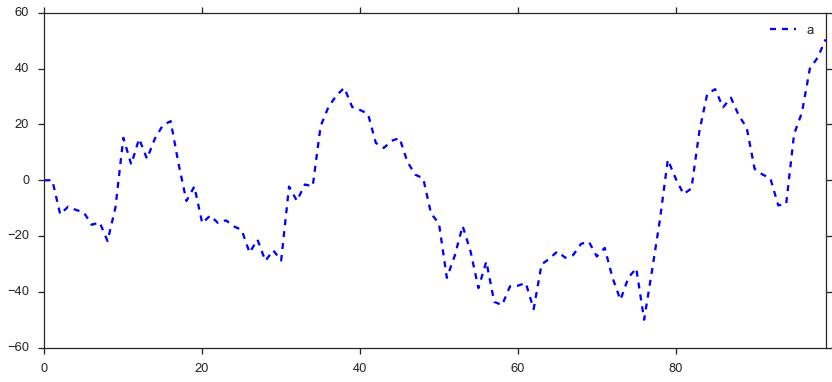

In [2]:
sigma_h = 10.0
h = np.random.normal(0, sigma_h, 110)
h[0] = 0.0
a = np.cumsum(h)

df = pd.DataFrame(a[0:100], columns=['a'])
_=df.plot(figsize=(14,6), style='b--')

Now we introduce a second time series that's just the original series, plus some noise:

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$


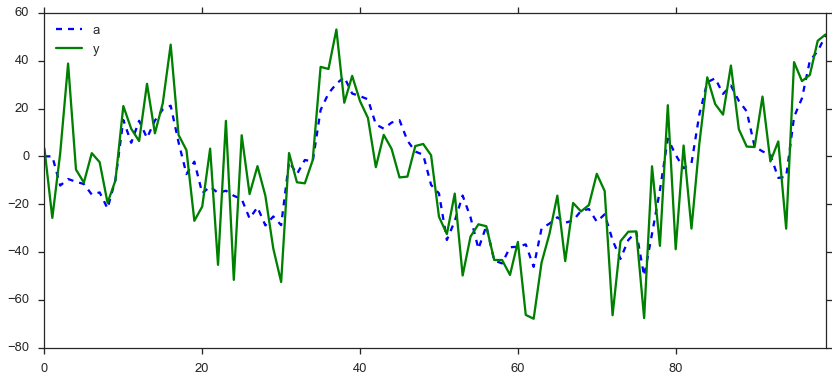

In [3]:
sigma_e = 15.
e = np.random.normal(0, sigma_e, 110)
df['y'] = a[0:100] + e[0:100]
_=df.plot(figsize=(14,6), style=['b--', 'g-',])

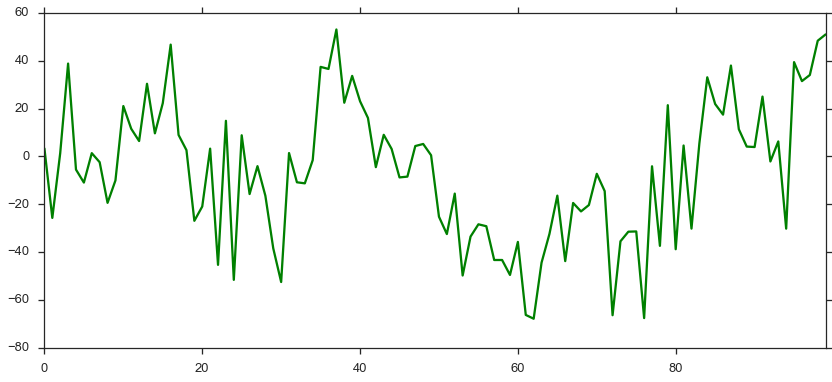

In [4]:
_=df.y.plot(figsize=(14,6), style=['g-',])

If we can only observe _y_, what can we say about &alpha;?

## State Space Model for Our Example


### State Equation

$$
\begin{align}
\alpha_{t+1} & = \alpha_{t} + \eta_t  & \eta_t \sim N(0, \sigma^2_{\eta}) \\
\end{align}
$$

### Observation (or Measurement) Equation

$$
\begin{align}
y_t & = \alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, \sigma_\varepsilon^2) \\
\end{align}
$$


- This is a simple structural time series model called the _local level model_.
- The state equation describes the _dynamics_ of the system, which are linear in the standard KF model


## Examples of State Space Systems
<table style="width:100%;">
<tr> <th style="padding:10px;"> State </th> <th> Observation </th></tr>
<tr> <td style="padding:10px;"> Signal </td> <td> Signal + Noise </td> </tr>
<tr> <td style="padding:10px;"> Position, Velocity </td> <td> Measurement from sensor </td> </tr>
<tr> <td style="padding:10px;"> Commodity price </td> <td> Futures price </td> </tr>
<tr> <td style="padding:10px;"> Position of cursor on screen </td> <td> Position of finger on trackpad </td> </tr>
</table>


## Linear State Space Models in General


### State Equation

$$
\begin{align}
\alpha_{t+1} & = T_t\alpha_{t} + R_t\eta_t  & \eta_t \sim N(0, Q_t) \\
\end{align}
$$

### Observation Equation

$$
\begin{align}
y_t & = Z_t\alpha_t + \varepsilon_t \qquad & \varepsilon_t \sim
    N(0, H_t) \\
\end{align}
$$


- _T_ is transition matrix
- _Q_ is state covariance
- _Z_ is design matrix
- _H_ is observation covariance
- _R_ is selection matrix


<img src='./data/pydata_chicago/StateSpaceClass.png'>

- This structure allows use of statsmodels time series framework and also allow custom state space models
- The Kalman smoother is the common technique for parameter estimation for AR models

In [5]:
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

kf = KalmanFilter(1,1)

kf.obs_cov = np.array([sigma_e]) # H
kf.state_cov = np.array([sigma_h])  # Q
kf.design = np.array([1.0])  # Z
kf.transition = np.array([1.0])  # T
kf.selection = np.array([1.0])  # R

ys, ah = kf.simulate(100)

- Here we use the KalmanFilter directly to make a state-space represantion of our local-level model
- In general, you would __not do this__, but rather use one of the model that uses the statsmodel time-series machinery

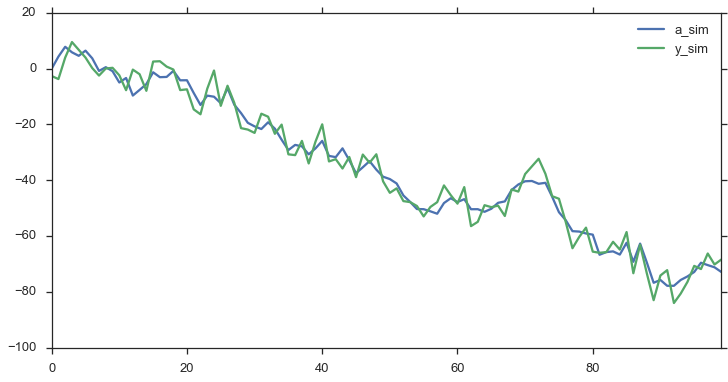

In [6]:
pd.DataFrame({'y_sim': ys.flatten(), 'a_sim': ah.flatten()}).plot(figsize=(12,6))

- This is just a simulation of our state space model given the parameters we've provided

<img src='data/pydata_chicago/KalmanEstimation.png'>

- Filtering is estimating the state for the latest observation y_t.
  - Ie, removing the noise
  - Nowcasting
- Smoothing/interpolation is estimating former states
  - Requires a forward filtering pass, and then a backward smoothing pass
- Prediction/forecasting is estimating the next state(s)

## The Kalman Filter Recursion for this Model

$$
\begin{align}
v_t & = y_t - a_t &  F_t  & = P_t + \sigma^2_\epsilon \\
a_{t|t} & = a_t + K_t v_t & P_{t|t} & = P_t(1-K_t) \\
a_{t+1} & = a_t + K_t v_t & P_{t+1} & = P_t(1-K_t) + \sigma^2_\eta\\
\end{align}
$$


## What We Know at Y<sub>t-1</sub>

- This conditional distribution:

$$
\begin{align}
p(\alpha_t | Y_{t-1}) & = N(a_t, P_t) \\
\end{align}
$$

- a<sub>t</sub> and P<sub>t</sub>
- The distribution of the forecast error, or _innovation_, v<sub>t</sub>, which is called F<sub>t</sub> above

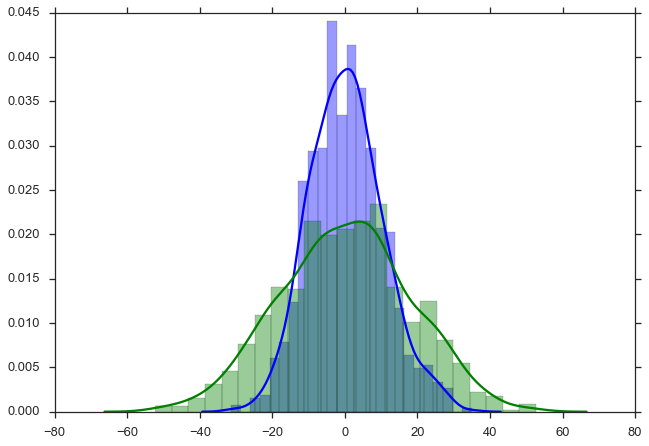

In [7]:
y_next = []
v_next = []
a_dist = np.random.normal(0, sigma_h, 1000)
a_1 = 0.
for i in range(1000):
    a_next = a_1 + np.random.normal(0, sigma_h)
    y_next.append(a_next + np.random.normal(0, sigma_e))
_=sns.distplot(a_dist, color='b', label='alpha')
_=sns.distplot(y_next, color='g', label='vt')

- The blue distribution is a simulation of our best guess of the next state
- The green distribution is a simulation of the distribution of the innovation (which here is also the distribution of y_t since a_t is 0)

## What We Know at Y<sub>t</sub>

 - The latest observation, y<sub>t</sub>
 - v<sub>t</sub> = y<sub>t</sub> - a<sub>t</sub>
 
 
 But ... also we know the relationship between &alpha;<sub>t</sub> and v<sub>t</sub>. How?

## Regression Lemma

$$
\begin{align}
E \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} \mu_a \\ \mu_b \end{pmatrix}, \quad
Var \begin{pmatrix} a \\ b \end{pmatrix} = \begin{pmatrix} \sigma^2_a & \sigma_{ab} \\ \sigma_{ab} & \sigma^2_b \end{pmatrix}
\end{align}
$$

$$
\begin{align}
E(a|b) & = \mu_a + \frac{\sigma_{ab}}{\sigma_b^2}(b-\mu_b) &  Var(a|b) & = \sigma^2 - \frac{\sigma_{ab}}{\sigma_b^2}(b-\mu_b) \\
\end{align}
$$



- a and b are jointly distributed normal variables
- this lemma describes the conditional distribution of a given b
- normally used to explain least-squares regression in terms of conditional distributions


$$
\begin{align}
\sigma_{\alpha_t v_t} & = Cov(\alpha_t,v_t|Y_{t}) \\
& = E[(\alpha_t - a_t)(v_t - 0)] \\
& = E[(\alpha_t - a_t)(\alpha_t + \epsilon_t - a_t)] = P_t
\end{align}
$$

$$
\begin{align}
E(\alpha_t|v_t) & = a_t + \frac{P_t}{P_t + \sigma^2_\epsilon}(y_t-a_t) &  Var(\alpha_t|v_t) & = \frac{P_t}{P_t+\sigma^2_\epsilon} \\
\end{align}
$$

This ratio:
$$
K = \frac{P_t}{P_t + \sigma^2_\epsilon}
$$

is called the _Kalman gain_

- Apply the lemma to alpha_t and v_t (given Y_t).
- The covariance gives us the relationship between the observed variable and the state
- Since the noise in the observation is assumed to be independent of the variance in the state, the covariance is Pt
- If the noise in the observation is small, then the Kalman gain is near one and tells us to adjust our state to near the observation
- If the noise is large compared to variance in state, then we're better off staying near a_t
- This lemma shows that the Kalman filter is the _optimal_ estimator for the linear and Gaussian case

## Filtering


$$
\begin{align}
a_{t|t} & = a_t + K_t v_t & P_{t|t} & = P_t(1-K_t) \\
\end{align}
$$
<br>

$$
\begin{align}
p(\alpha_t | Y_t) & = N(a_{t|t}, P_{t|t}) \\
\end{align}
$$
<br>

$$
\begin{align}
Y_t & = \{y_1, y_2, \dots , y_t\} \\
a_{t|t} & = E(\alpha_t|Y_t) \\
P_{t|t} & = Var(\alpha_t|Y_t) \\
\end{align}
$$


- Filtering improves our estimate of the current state given the latest observation (optimally).
- We are really determining a new conditional distribution of the state

In [8]:
# Initialize known state
kf.initialize_known(np.array([0.0]), np.array([[sigma_h]]))
# Bind data
y = a + e
kf.bind(y.copy())
r = kf.filter()

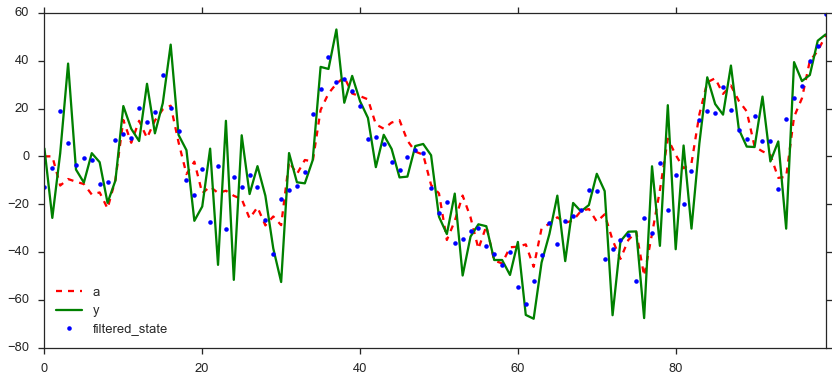

In [27]:
df['filtered_state'] = r.filtered_state[0][1:101]
df[['a', 'y', 'filtered_state']].plot(figsize=(14,6), style=['r--', 'g-', 'b.'])

## Forecasting

$$
\begin{align}
a_{t+1} & = a_t + K_t v_t & P_{t+1} & = P_t(1-K_t) + \sigma^2_\eta\\
\end{align}
$$
<br>

$$
\begin{align}
p(\alpha_{t+1} | Y_t) & = N(a_{t+1}, P_{t+1}) \\
\end{align}
$$
<br>

$$
\begin{align}
Y_t & = \{y_1, y_2, \dots , y_t\} \\
a_{t+1} & = E(\alpha_{t+1}|Y_t) \\
P_{t+1} & = Var(\alpha_{t+1}|Y_t) \\
\end{align}
$$


- In the local-level case the forecast is the same as the filtering.
- Notice though that the variance gets larger with each time step

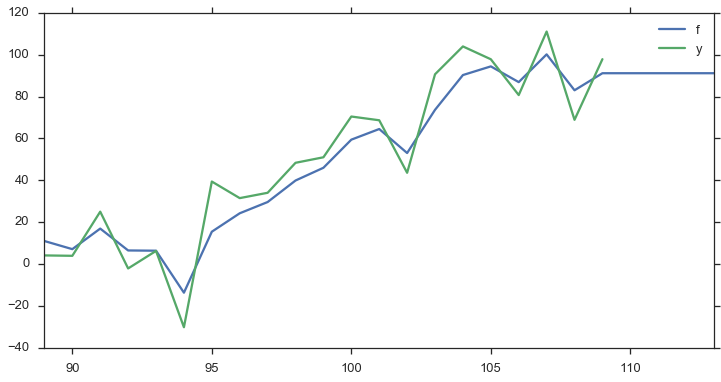

In [10]:
p = r.predict(90, 115, dynamic=20)
s_f = pd.Series(p.results.forecasts[0][1:])
s_y = pd.Series(y)
pd.DataFrame({'y':s_y, 'f':s_f}).iloc[-25:].plot(figsize=(12,6))

- For the local level model, the forecast will always be a horizontal line at the last estimated state value
- However, the _uncertainty_ in this forecast gets progressively larger
- Note that the Kalman filter is time invariant

## Things We've Ignored

- We usually don't know parameters in our model like &sigma;<sup>2</sup><sub>&epsilon;</sub> and &sigma;<sup>2</sup><sub>&eta;</sub>
  - This is why we use the MLEModel-derived classes
- We need to initialize the first state
  - Diffuse prior


## The Kalman Filter Recursion in General

$$
\begin{align}
v_t & = y_t - Z_T a_t &  F_t  & = Z_t P_t Z_t' + H_t \\
a_{t|t} & = a_t + P_t Z_t' F^{-1}_t v_t & P_{t|t} & = P_t - P_t Z_t' F^{-1}_t Z_t P_t \\
a_{t+1} & = T_t a_t + K_t v_t & P_{t+1} & = T_t P_t(T_t - K_t Z_t)' + R_t Q_t R_t'\\
\end{align}
$$


- Main differences between simpler model:
  - Design matrix affects innovation and forecast error (Ft)
  - Transition matrix affects dynamics of states

## Unobserved Components Models

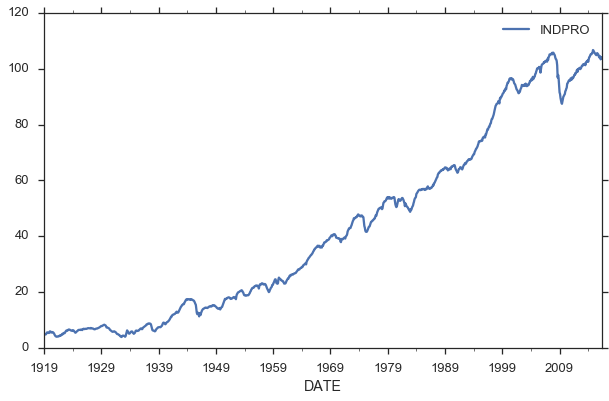

In [59]:
df_indpro = pd.read_csv('./data/pydata_chicago/INDPRO.csv', parse_dates=['DATE'])
df_indpro.set_index('DATE', inplace=True)
df_indpro.head()
_ =df_indpro.plot(figsize=(10,6))

- Unobserved components models are structural models
- State space models work well with non-stationary time series.
- This data shows industrial production where we have a clear trend

### Local Linear Trend Model
$$
\begin{align}
   y_t & = \mu_t + \epsilon_t \\
   \mu_{t+1} & = \mu_t + \nu_t + \xi_t \\
   \nu_{t+1} & = \nu_t + \zeta_t \\
\end{align}
$$

### State Space
$$
\begin{align}
   y_t & = \begin{bmatrix} 1 & 0 \end{bmatrix} \begin{bmatrix} \mu_t \\ \nu_t \end{bmatrix}  + \epsilon_t \\
   \begin{bmatrix} \mu_{t+1} \\ \nu_{t+1} \end{bmatrix} & = \begin{bmatrix}
      1 & 1 \\
           0 &      1
   \end{bmatrix} \begin{bmatrix} \mu_t \\ \nu_t \end{bmatrix} + \begin{bmatrix} \xi_t \\ \zeta_t \end{bmatrix}
\end{align}
$$


In [62]:
from statsmodels.tsa.statespace.structural import UnobservedComponents

indpro_mod = UnobservedComponents(df_indpro.INDPRO,
                                  level=True,
                                  trend=True,
                                  stochastic_level=True,
                                  stochastic_trend=True)
indpro_res = indpro_mod.fit(method='powell', disp=False)
#indpro_res.summary()

## Forecasting with the Local Linear Trend Model

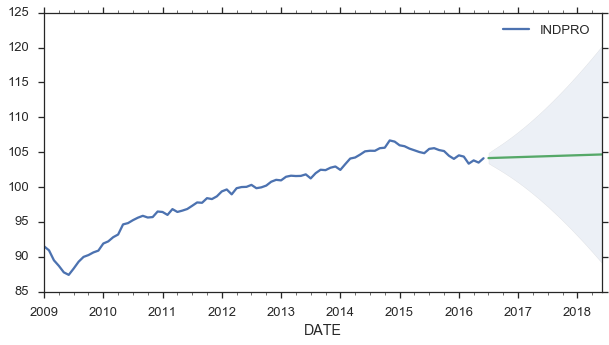

In [64]:
fig, ax = plt.subplots(figsize=(10,5))

fres = indpro_res.get_forecast('2018-06-01')
df_indpro.ix['2009-01-01':].plot(ax=ax)
fres.predicted_mean.plot()
fres_ci = fres.conf_int()
_=ax.fill_between(fres_ci.index, fres_ci['lower INDPRO'], fres_ci['upper INDPRO'], alpha=0.1)

- The forecast here will start with the last filtered level and the maintain a constant slope

## Other State Space Models: AR(p)

### Normally (p=2)
$$
   y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \epsilon_t
$$

### State Space
$$
\begin{align}
   y_t & = \begin{bmatrix} 1 & 0 \end{bmatrix} \alpha_t \\
   \alpha_{t+1} & = \begin{bmatrix}
      \phi_1 & \phi_2 \\
           1 &      0
   \end{bmatrix} \alpha_t + \begin{bmatrix} 1 \\ 0 \end{bmatrix} \eta_t
\end{align}
$$

$$
\begin{align}
   \alpha_t & = \begin{bmatrix} y_t \\ y_{t-1} \end{bmatrix} \\
\end{align}
$$


- Part of the appeal of state-space models is that many traditional time-series models can be put into state-space form
- Including all variants of ARIMA

Where

$$
   Z_t \equiv Z = \begin{bmatrix} 1 & 0 \end{bmatrix}
$$

and

$$
\begin{align}
   T_t \equiv T & = \begin{bmatrix}
      \phi_1 & \phi_2 \\
           1 &      0
   \end{bmatrix} \\
   R_t \equiv R & = \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
   \eta_t & \sim N(0, \sigma^2)
\end{align}
$$

## SARIMAX Model of Industrial Electricity Sales

In [24]:
df_esales = pd.read_csv('./data/pydata_chicago/esales.csv', parse_dates=['Month'])
df_esales.set_index('Month', inplace=True)
df_esales['petrol'] = df_esales.petrol.interpolate()
for v in ('coal', 'gas', 'petrol', 'elec'):
    df_esales['l'+v] = np.log(df_esales[v]).diff()
df_esales = df_esales.dropna()
df_esales.head(2)

,Usage,logUsage,coal,gas,petrol,elec,INDPRO,DlINDPRO,lcoal,lgas,lpetrol,lelec
Month,,,,,,,,,,,,
2008-02-01,81484.31279,11.308166,1.8742,8.6599,15.4001,6.34,105.0540,-0.003354,0.003849,0.040341,0.028520,0.001579
2008-03-01,83497.98014,11.332578,1.9133,9.2982,15.2342,6.46,104.7987,-0.002433,0.020648,0.071118,-0.010831,0.018751


- This is an attempt to build a state-space based ARIMAX model of industrial electric sales
- According to the literature, this should be influenced by industrial production, and also the price of other energy sources

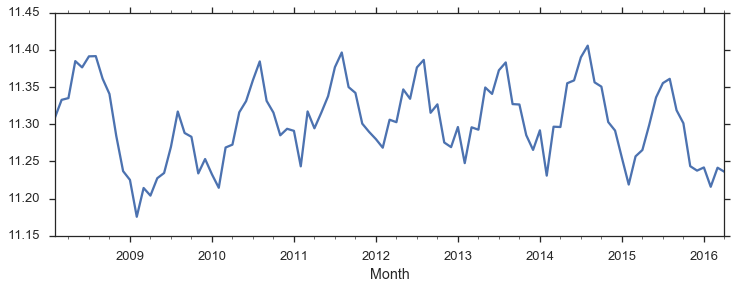

In [15]:
_=df_esales.logUsage.plot(figsize=(12,4))

- The series has a fairly obvious seasonal aspect

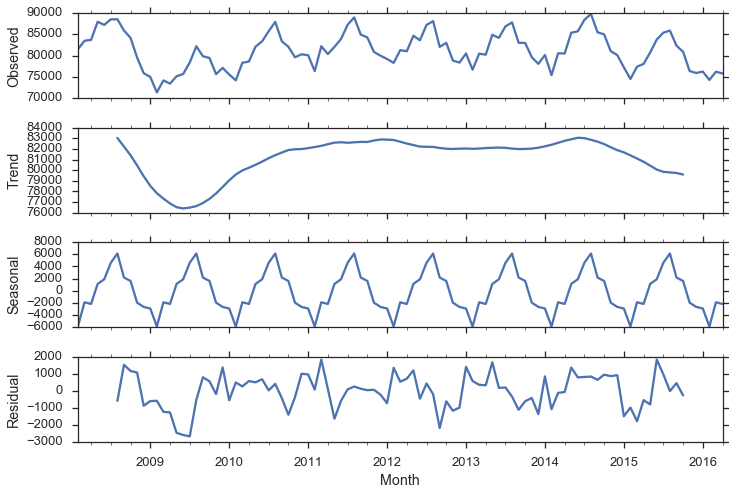

In [16]:
import statsmodels.tsa.api as smt
f=plt.figure(figsize=(12,6))
_=smt.seasonal_decompose(df_esales.Usage).plot()

- The residuals look like they might have a second seasonal component

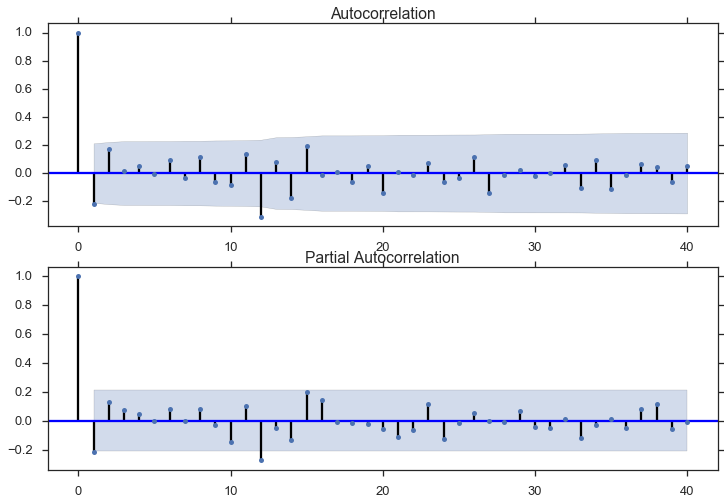

In [32]:
sdiff = df_esales.logUsage.diff(12) # Seasonal diff
i1_sdiff = sdiff.dropna().diff().dropna()
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = smt.graphics.plot_acf(i1_sdiff, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = smt.graphics.plot_pacf(i1_sdiff, lags=40, ax=ax2)

- Doing a seasonal difference and a regular differencing of the log series leave a significant AR term at lag 12(in PACF) and a MA term at lag 12 (from ACF).
- Borderline AR and MA terms at lag 1, but we get better AIC without them

In [61]:
import statsmodels.api as sm
# Variables
endog = df_esales.logUsage
exog = sm.add_constant(df_esales[['lcoal', 'lgas', 'lpetrol', 'lelec', 'DlINDPRO']])

# Fit the model
ar_mod = smt.statespace.SARIMAX(endog, order=(0,1,0), seasonal_order=(1,1,1,12))
ar_res = ar_mod.fit()
#ar_res.summary()

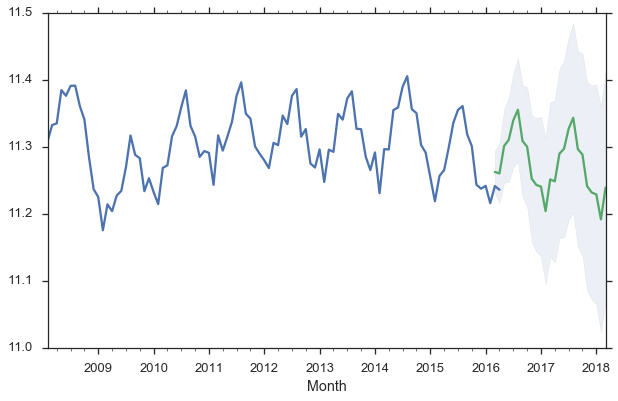

In [43]:
ar_p = ar_res.get_prediction('2016-03-01', '2018-03-01', dynamic=True)

fig, ax = plt.subplots(figsize=(10,6))
df_esales.logUsage.plot(ax=ax)
ar_p.predicted_mean.plot(ax=ax)
ar_p_ci = ar_p.conf_int()
_=ax.fill_between(ar_p_ci.index, ar_p_ci['lower logUsage'], ar_p_ci['upper logUsage'], alpha=0.1)

In [60]:
# Fit the model
arx_mod = smt.statespace.SARIMAX(endog[:'2014-03-01'], exog[:'2014-03-01'], order=(0,1,0), seasonal_order=(1,1,1,12))
arx_res = arx_mod.fit()
#arx_res.summary()

/Users/mikemull/anaconda/envs/hamilton/lib/python3.5/site-packages/statsmodels-0.8.0-py3.5-macosx-10.6-x86_64.egg/statsmodels/base/model.py:489: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


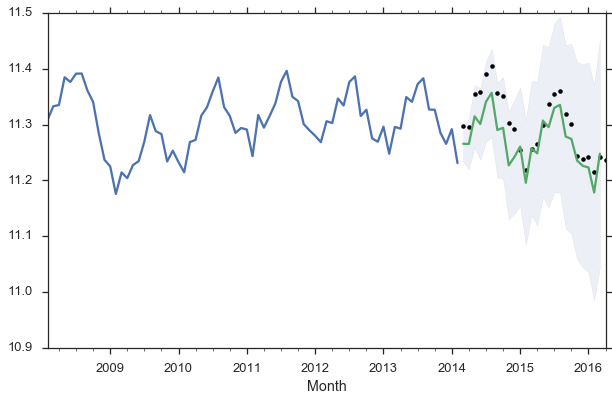

In [65]:
arx_p = arx_res.get_prediction('2014-03-01', '2016-03-01', exog=exog.ix['2014-05-01':],dynamic=True)

fig, ax = plt.subplots(figsize=(10,6))
df_esales.logUsage.ix[:'2014-02-01'].plot(ax=ax)
df_esales.logUsage.ix['2014-03-01':].plot(ax=ax, style='k.')
arx_p.predicted_mean.plot(ax=ax)
arx_p_ci = arx_p.conf_int()
_=ax.fill_between(arx_p_ci.index, arx_p_ci['lower logUsage'], arx_p_ci['upper logUsage'], alpha=0.1)

## Extensions and Variations of the Kalman Filter

- Extended Kalman filter
- "Unscented" Kalman filter (sigma point filter)
- Particle filters

## References

- Durbin and Koopman, Time Series Analysis by State-Space Methods
- [How Kalman Filters Work](http://www.anuncommonlab.com/articles/how-kalman-filters-work/)